In [5]:
# use dream_proj conda environment
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy.stats import pearsonr, spearmanr
import statsmodels.formula.api as smf

# auto reload source files
%load_ext autoreload
%autoreload 2
# add source directory to path
source_path = os.path.abspath(os.path.join('..'))
if source_path not in sys.path:
    sys.path.append(os.path.join(source_path, 'source'))
# read source files
import read_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read data

In [27]:
loader = read_data.DatasetLoader("CPTAC-3", load_methylation=False)
cptac_expr, cptac_mut, cptac_methyl = loader.load_dataset()

Loading dataset: CPTAC-3
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_expression.tsv
Loaded metadata for CPTAC-3
Created ExpressionDataset for CPTAC-3
Created MutationDataset for CPTAC-3


In [10]:
# write columnbs of cptac_expr.expression_df to file, one on each line
cptac_expr.expression_df.columns.to_series().to_csv("/cellar/users/zkoch/dream/utilities/cptac3_ensembl_gene_names.tsv", index=False, columns=None, header=False)

# DREAM expression vs. mutation burden

### Get DREAM regulated expression

In [3]:
cptac_expr.get_dream_gene_expression(
    #row_limiting_query = "dna_repair_genes == True"
    )   
# get rows that start with 'C3N-00150'
cptac_expr.dream_expression['mean_dream_reg_expr'] = cptac_expr.dream_expression[cptac_expr.dream_regulated_genes_w_expression].mean(axis=1)
cptac_expr.dream_expression['median_dream_reg_expr'] = cptac_expr.dream_expression[cptac_expr.dream_regulated_genes_w_expression].median(axis=1)

Did not need to convert DREAM genes
Found 322 DREAM genes with expression


##### Dream regulated genes are upregulated in tumors

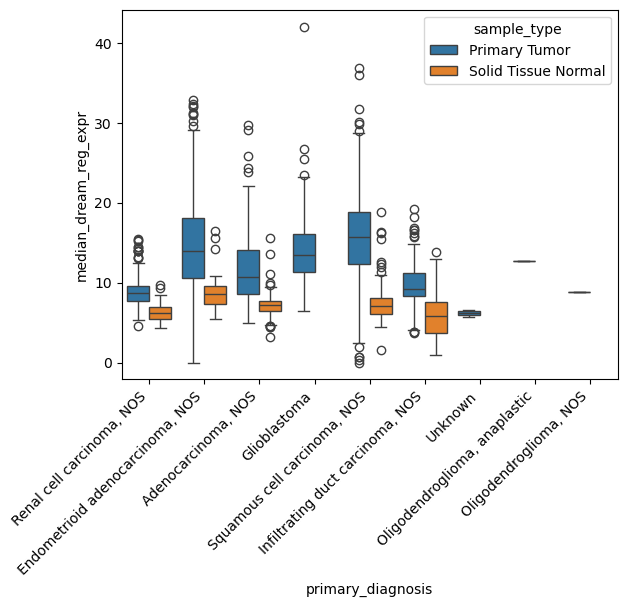

In [4]:
# all dream 
sns.boxplot(
    data = cptac_expr.dream_expression,
    x = 'primary_diagnosis', 
    y = 'median_dream_reg_expr',
    hue = 'sample_type'
    )
# angle the x-axis labels
_ = plt.xticks(rotation=45, ha='right')

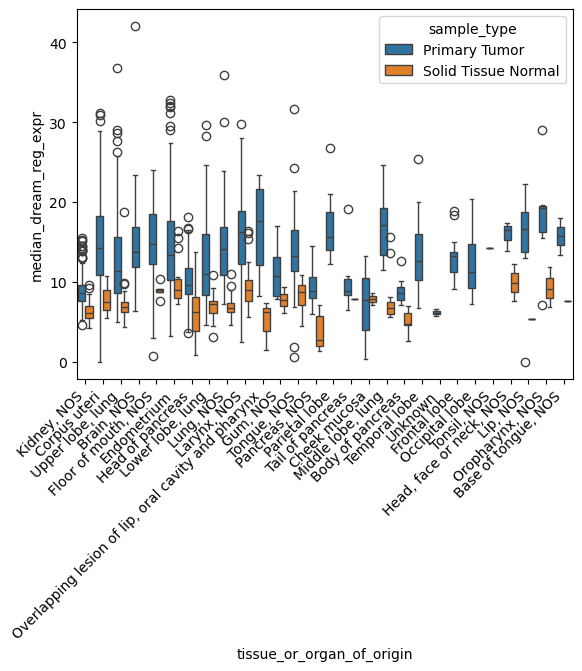

In [5]:
# all dream 
sns.boxplot(
    data = cptac_expr.dream_expression, 
    x = 'tissue_or_organ_of_origin', 
    y = 'median_dream_reg_expr', 
    hue = 'sample_type'
    )
# angle the x-axis labels
_ = plt.xticks(rotation=45, ha='right')

##### Dream regulated gene expression does not change with age

In [50]:
normal_tissue_dream_expr = cptac_expr.dream_expression.query("sample_type == 'Solid Tissue Normal'")
spearmanr(normal_tissue_dream_expr['age_at_index'],normal_tissue_dream_expr['median_dream_reg_expr'], nan_policy='omit')

SignificanceResult(statistic=0.024355987577852945, pvalue=0.5475794260859248)

In [55]:
tumor_tissue_dream_expr = cptac_expr.dream_expression.query("sample_type == 'Primary Tumor'")
spearmanr(tumor_tissue_dream_expr['age_at_index'],tumor_tissue_dream_expr['median_dream_reg_expr'], nan_policy='omit')

SignificanceResult(statistic=0.0063928419320996585, pvalue=0.803078946134151)

#### Deconvolving cell-cyle

In [ ]:
# based on the expression profile of each individual, infer the cell cycle composition of the tumor
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5590068/

import 

### Get mutation burdens

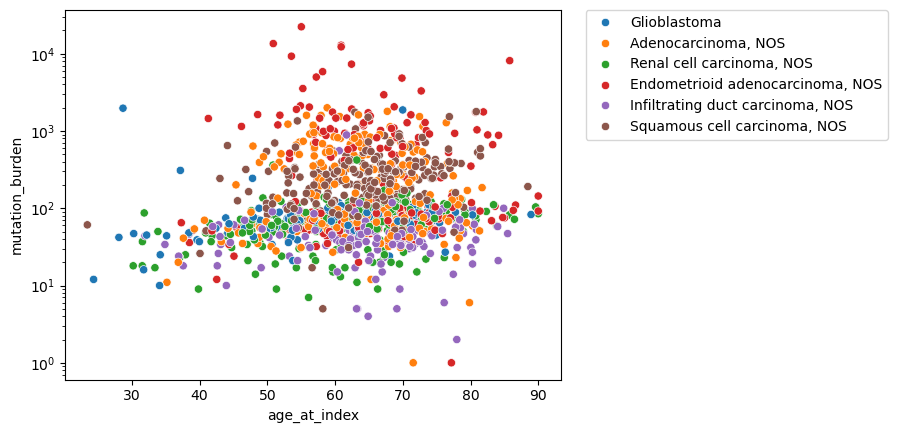

In [6]:
sns.scatterplot(
    data = cptac_mut.mutation_burden.query("num_samples_this_case == 1"),
    x = 'age_at_index', y = 'mutation_burden', hue = 'primary_diagnosis', 
    )
plt.yscale('log')
# move legend onto plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Compare dream expression to mutation burden

In [90]:
# have to join on case_id because there are no sample_ids with mutation for normal tissue
normal_tissue_dream_expr = cptac_expr.dream_expression.query("sample_type == 'Solid Tissue Normal'")
normal_expr_v_burden = normal_tissue_dream_expr.merge(
    cptac_mut.mutation_burden[['case_id', 'mutation_burden']], 
    on='case_id', how = 'left'
    )
normal_expr_v_burden.query("tissue_or_organ_of_origin == 'Kidney, NOS'")[['mean_dream_reg_expr', 'median_dream_reg_expr', 'mutation_burden']].corr(method='spearman')

mean_dream_reg_expr  median_dream_reg_expr  \
mean_dream_reg_expr               1.000000               0.927457   
median_dream_reg_expr             0.927457               1.000000   
mutation_burden                   0.069416               0.124303   

                       mutation_burden  
mean_dream_reg_expr           0.069416  
median_dream_reg_expr         0.124303  
mutation_burden               1.000000

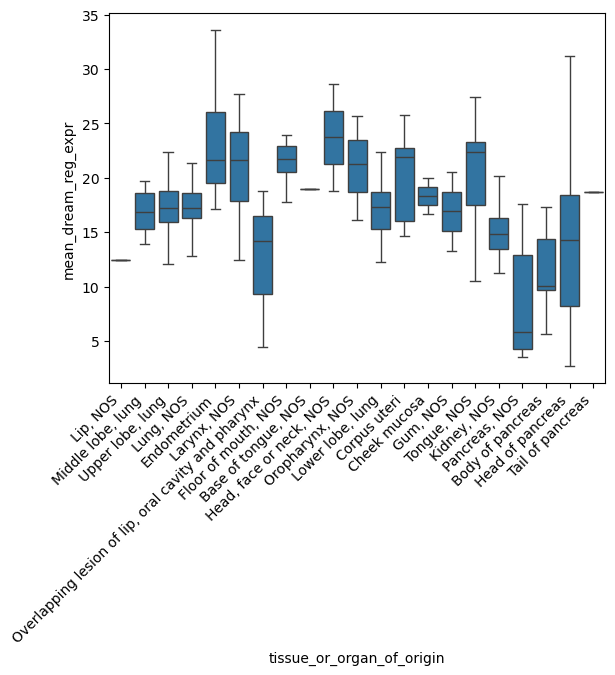

In [129]:
mean_expr_order = normal_expr_v_burden.groupby('tissue_or_organ_of_origin')['mean_dream_reg_expr'].median().sort_values(ascending=False).index
sns.boxplot(
    data = normal_expr_v_burden, x = 'tissue_or_organ_of_origin', 
    y = 'mean_dream_reg_expr', showfliers=False,
    order=burden_order
    )
# angle the x-axis labels
_ = plt.xticks(rotation=45, ha='right')

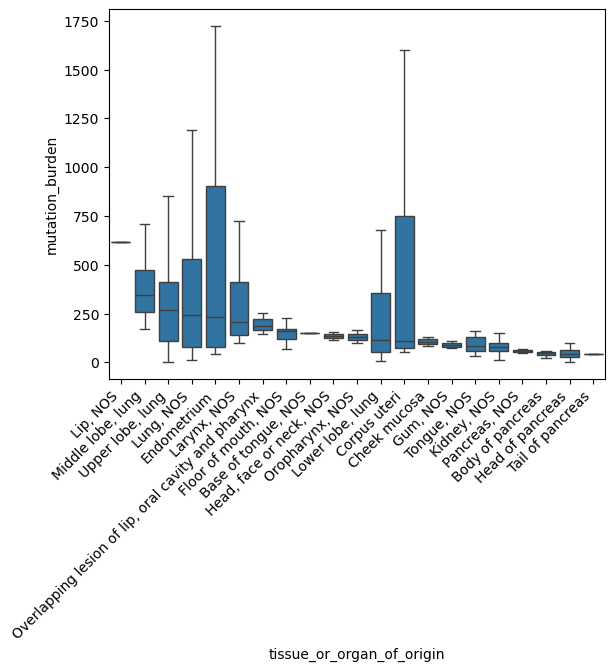

In [128]:
burden_order = normal_expr_v_burden.groupby('tissue_or_organ_of_origin')['mutation_burden'].median().sort_values(ascending=False).index
sns.boxplot(data = normal_expr_v_burden, x = 'tissue_or_organ_of_origin', y = 'mutation_burden', showfliers=False, order=burden_order)
# angle the x-axis labels
_ = plt.xticks(rotation=45, ha='right')

In [115]:
normal_expr_v_burden.groupby('tissue_or_organ_of_origin')[
    ['mean_dream_reg_expr', 'median_dream_reg_expr', 'mutation_burden']
    ].mean().corr(method='spearman')

mean_dream_reg_expr  median_dream_reg_expr  \
mean_dream_reg_expr               1.000000               0.964935   
median_dream_reg_expr             0.964935               1.000000   
mutation_burden                   0.328571               0.235065   

                       mutation_burden  
mean_dream_reg_expr           0.328571  
median_dream_reg_expr         0.235065  
mutation_burden               1.000000

In [116]:
dream_exp_v_mut_burden.groupby('tissue_or_organ_of_origin_x')[
    ['mean_dream_reg_expr', 'median_dream_reg_expr', 'mutation_burden']
    ].mean().corr(method='spearman')

mean_dream_reg_expr  median_dream_reg_expr  \
mean_dream_reg_expr               1.000000               0.918993   
median_dream_reg_expr             0.918993               1.000000   
mutation_burden                   0.385983               0.433846   

                       mutation_burden  
mean_dream_reg_expr           0.385983  
median_dream_reg_expr         0.433846  
mutation_burden               1.000000

In [88]:
# join on sample_id
dream_exp_v_mut_burden = cptac_expr.dream_expression.merge(
     cptac_mut.mutation_burden, left_index=True, right_index=True, how='left'
    )
dream_exp_v_mut_burden.query("sample_type == 'Primary Tumor' and tissue_or_organ_of_origin_x == 'Kidney, NOS'")[
    ['mean_dream_reg_expr', 'median_dream_reg_expr', 'mutation_burden']
    ].dropna().corr(method='spearman')

mean_dream_reg_expr  median_dream_reg_expr  \
mean_dream_reg_expr               1.000000               0.913296   
median_dream_reg_expr             0.913296               1.000000   
mutation_burden                   0.110827               0.147713   

                       mutation_burden  
mean_dream_reg_expr           0.110827  
median_dream_reg_expr         0.147713  
mutation_burden               1.000000

<Axes: >

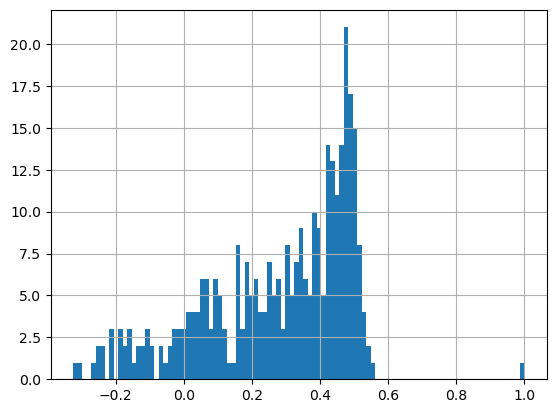

In [112]:
dream_exp_v_mut_burden[
    dream_exp_v_mut_burden.columns[dream_exp_v_mut_burden.dtypes == 'float64']
    ].corr(method='spearman')['mutation_burden'].sort_values(ascending=False).hist(bins = 100)

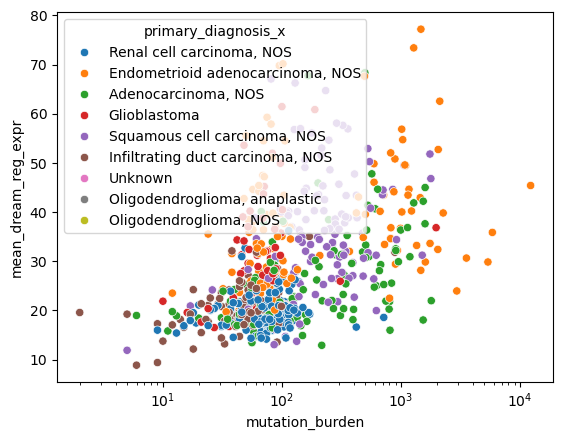

In [11]:
sns.scatterplot(
    data = dream_exp_v_mut_burden.query("sample_type == 'Primary Tumor'"), 
    y = 'mean_dream_reg_expr', x = 'mutation_burden', hue = 'primary_diagnosis_x'
    )
plt.xscale('log')